# 词义消歧 Word Sense Disambiguation (снятие лексической неоднозначности) и 词义归纳 Word Sense Induction (нахождение значений слова)

WSD 词义消歧 и WSI 词义归纳 - это связанные задачи про определение значений, в которых употребляются слова. WSI занимается определением возможных значений слова, а WSD нужна для того, чтобы определить, в каком из имеющихся значений слово употреблено в тексте. 
确定词使用的含义。WSI:归纳所有可能的含义；WSD:在上下文中使用的含义。

На прошлых занятиях мы вообще закрывали глаза на то, что у слов может быть несколько значений, т.к. в целом это не такая уж серьезная проблема. Однако в некоторых практических задачах учёт многозначности может сильно помочь (например, в поиске результат будет отличаться для запросов "гоголь фильм" и "гоголь писатель")

在特定的上下文中的词的意义
Основное предположение, на котором строятся все модели для снятия и определения неоднозначности - значение определяется в контексте (отличие от эмбедингов в том, что тут имеется в виду конкретный контекст и конкретное значение, а не набор всех контекстов и общее значение=смысл слова). Т.к контекст может включать в себя невероятного много всего (от 1 соседнего слова до актуальных мемов), решить задачу полностью пока нельзя и это, наверное, сложная и интересная тема для исследований. На ACL прошлого года одна из oustanding работ как раз про **WSD** - 
https://github.com/malllabiisc/EWISE  
Но в рамках семинара давайте посмотрим, какие есть уже готовые инструменты или простые алгоритмы для работы с многозначностью.

对单词出现的上下文（窗口）进行聚类
**WSI** можно представить как задачу кластеризации контекстов, в которых встречается слово (тут и дальше контекст - это окно в несколько слов, стоящих рядом с целевым словом в каком-то тексте). Мы попробуем это поделать на следующем семинаре по машинному обучению.

А сейчас попробуем Адаграм!
Adagram (Adaptive Skip-gram, 自适应跳频模型) 是一种在word2vec软件中实现的名为per模型的非参数扩展，能够学习不同词义。基于非参数贝叶斯方法实现动态多义（dynamic polysemy）。

In [1]:
import adagram
from lxml import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from pymorphy2 import MorphAnalyzer
from string import punctuation
import json, os
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))



def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split() if word and word not in stops]
    words = [word for word in words if word]

    return words

def normalize(text):
    
    words = tokenize(text)
    words = [morph.parse(word)[0].normal_form for word in words if word]

    return words

## Адаграм

Word2Vec и Fasttext каждому слову (или буквенному нграму) сопоставляют 1 вектор. Это значит, что у каждого слова в векторном пространстве только 1 значение. У многозначных слов векторы будут просто каким-то усреднением или обобщением всех его значений. 
Word2Vec和Fasttext每个单词（或字母ngram）映射1个向量。 这意味着向量空间中的每个单词只有1个含义。 对于多义词，向量将只是其所有词义平均或概括。

В работе https://arxiv.org/pdf/1502.07257.pdf предлагается способ улучшить Skip Gram, так чтобы каждому слову сопостовлялось K различных векторов, так что каждый из них представляет какое-то из его значений. При этом сам параметр K задавать не нужно, модель сама находит нужное количество "значений" для каждого слова (т.е. делает WSI).
优化Skip-gram的方法，每个词有不同的K个向量，分别表示不同的词义。模型自动为每个词找到词义数量K（即形成WSI）

Изначально этот  подход реализован на julia, но есть реализация на питоне - https://github.com/lopuhin/python-adagram

In [37]:
!pip install Cython numpy
!pip install git+https://github.com/lopuhin/python-adagram.git

  Cloning https://github.com/lopuhin/python-adagram.git to /private/var/folders/sw/k25rhtrn2psc2hztd0t4tqmh0000gn/T/pip-req-build-9w1jahw3
  Running command git clone -q https://github.com/lopuhin/python-adagram.git /private/var/folders/sw/k25rhtrn2psc2hztd0t4tqmh0000gn/T/pip-req-build-9w1jahw3
  Created wheel for adagram: filename=adagram-0.0.1-cp36-cp36m-macosx_10_15_x86_64.whl size=229290 sha256=d26eca1434831ee4aad00276e2fae0ca6c5e1ac0eaf151bea5aa092e396a4e02
  Stored in directory: /private/var/folders/sw/k25rhtrn2psc2hztd0t4tqmh0000gn/T/pip-ephem-wheel-cache-jtv6tcb6/wheels/d4/94/02/8c84fcc5d21cf2825971f268d8367c25dd78b6c0bf5743f644
Successfully built adagram


Обучается адаграм через командную строку.

Возьмем небольшой новостной корпус. Нормализуем.

In [3]:
corpus = open('corpus_ng.txt', encoding="utf-8").read()
corpus = normalize(corpus)

In [4]:
corpus[:10]

['бой',
 'сопоцкина',
 'друскеник',
 'закончиться',
 'отступление',
 'германец',
 'неприятель',
 'приблизиться',
 'север',
 'осовца']

И положим одним куском в файл.

In [6]:
# 词 词 词 ...
f = open('corpus.txt', 'w', encoding='utf-8')
f.write(' '.join(corpus))
f.close()

Обучим модель (обучается достаточно долго)

In [ ]:
!adagram-train corpus.txt out.pkl

Обученная модель загружается вот так.

In [2]:
vm = adagram.VectorModel.load("out.pkl")

In [6]:
# модель обученная на большом корпусе (осторожно 1.5 гб)
# !wget 'https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib'
# vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

Посмотрим на значения каких-нибудь слова.

In [3]:
vm.word_sense_probs('мир')
# возвращается список туплов, где первая цифра - номер значения, а вторая - вероятность (распространенность) этого значения
# 第一个数：该词的第几个词义；第二个数：同义概率。这个词共两个词义。

[(0, 0.7585169498833962), (1, 0.24146439423939348)]

Посмотрим какие слова близки к каждому из значений.

In [4]:
vm.sense_neighbors('мир', 0) # первое значение слова мир

[('чемпионат', 0, 0.71359706),
 ('футбол', 0, 0.63420445),
 ('самый', 0, 0.5430565),
 ('количественный', 0, 0.53455245),
 ('место', 1, 0.52710235),
 ('двухметровый', 0, 0.5229766),
 ('который', 0, 0.5075667),
 ('трофей', 0, 0.4926684),
 ('стартовать', 0, 0.4906729),
 ('матч', 0, 0.48958433)]

In [5]:
vm.sense_neighbors('мир', 1) # второе

[('сша', 2, 0.4559447),
 ('отделять', 0, 0.43212086),
 ('директор-распорядитель', 0, 0.4233097),
 ('арафат', 0, 0.41910806),
 ('думать', 0, 0.41224533),
 ('ясный', 0, 0.4083918),
 ('уик-энд', 0, 0.40513057),
 ('реликвия', 0, 0.4044521),
 ('коррумпировать', 0, 0.40200907),
 ('конструктор', 0, 0.40080503)]

Чтобы не гадать, можно посмотреть на все слова у которых есть хотя бы 2 устойчивых значения.

In [6]:
ambiguous = []
for word in vm.dictionary.id2word:
    probs = vm.word_sense_probs(word)
    if len(probs) > 1 and probs[0][1] < 0.8: # второе условие нужно, чтоб выкинуть слова с не очень сильным вторым значением
        ambiguous.append(word)

In [7]:
ambiguous

['который',
 'год',
 'сообщать',
 'россия',
 'тот',
 'один',
 'это',
 'свой',
 'время',
 'также',
 'человек',
 'российский',
 'слово',
 'дело',
 'сша',
 'москва',
 'представитель',
 'суд',
 'страна',
 'однако',
 'стать',
 'быть',
 'находиться',
 'место',
 'город',
 'такой',
 'правительство',
 'должный',
 'около',
 'новый',
 'министр',
 'несколько',
 'другой',
 'американский',
 'информация',
 'работа',
 'передавать',
 'вопрос',
 'самый',
 'сотрудник',
 'являться',
 'данные',
 'рф',
 'власть',
 'сказать',
 'мнение',
 'весь',
 'дать',
 'сторона',
 'этот',
 'напомнить',
 'провести',
 'среда',
 'мир',
 'часть',
 'вторник',
 'программа',
 'александр',
 'система',
 'местный',
 'три',
 'имя',
 'состояться',
 'первое',
 'ряд',
 'ситуация',
 'ближний',
 'начало',
 'объявить',
 'момент',
 'из-за',
 'счёт',
 '20',
 'столица',
 'составить',
 'проблема',
 'апрель',
 '15',
 'подобный',
 'уровень',
 'представить',
 'утверждение']

Определить значение по контексту можно вот так:

In [8]:
vm.disambiguate("мир", ['чемпионат', "россия", "игра", "футбол"]) # выдает вероятности

array([9.99999390e-01, 6.10483239e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [9]:
# достаем номер самого вероятного значения
# 找出最可能的词义的编号
vm.disambiguate("мир", ['чемпионат', "россия", "игра", "футбол"]).argmax()

0

А вектор нужно смысла можно достать вот так:

In [10]:
# 该编号的矢量
v = vm.sense_vector("мир", 0)

In [89]:
v.shape

(100,)

Как и с другими векторными моделями, проверять Адаграм нужно на реальной задаче.

## Задание № 1. Протестировать адаграм в определении перефразирования

In [13]:
import pandas as pd
corpus_xml = html.fromstring(open('paraphraser/paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [14]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [15]:
data[:5]

,text_1,text_2,label,text_1_norm,text_2_norm
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,"[полицейский, разрешить, стрелять, поражение, ...","[полиция, мочь, разрешить, стрелять, хулиган, ..."
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,"[право, полицейский, проникновение, жилища, ре...","[правило, внесудебный, проникновение, полицейс..."
2,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,0,"[президент, египет, ввести, чрезвычайный, поло...","[власть, египет, угрожать, ввести, страна, чре..."
3,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...,-1,"[вернуться, сирия, россиянин, волновать, вопро...","[самолёт, мчс, вывезти, россиянин, разрушить, ..."
4,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...,0,"[москва, сирия, вернуться, 2, самолёт, мчс, ро...","[самолёт, мчс, вывезти, россиянин, разрушить, ..."


Векторизуйте пары текстов с помощью Адаграма, обучите любую модель и оцените качество (кросс-валидацией). 
用adagram矢量化成对的文本，训练任意模型，交叉验证模型质量

За основу возьмите код из предыдущего семинара/домашки, только в функции 
get_embedding вам нужно выбирать вектор нужного значения (импользуйте model.disambiguate и model.sense_vector). Отдельные векторы усредните как и в предыдущем семинаре.
上节课的代码，在get_embedding函数中需要添加选需要的词义的代码（用model.disambiguate 和 model.sense_vector）。单义词按原来的方式取平均值

Для вытаскивания пар (целевое слово, контекстые слова) вам нужно будет написать специальную функцию.
编写函数提取对（目标词，上下文词）

In [24]:
# проверяте на списке из чисел, чтобы было удобно дебажить
# 检查数字列表以方便使用
words = [0,1,2,3,4,5,6,7,8,9]

def get_words_in_context(words, window=3):
    """Ваш код здесь """

    return words_in_context

In [62]:
# words = [0,1,2,3,4,5,6,7,8,9]
def get_words_in_context(words, window=3):
    words_context = []
    for i, w in enumerate(words):
        context = [words[c] for c in range(i - window, i + window + 1) if c != i and  c >= 0 and c < len(words)]  
        words_context.append([w, context])
    return words_context

In [61]:
# работать должно вот так
get_words_in_context(words)

[[0, [1, 2, 3]],
 [1, [0, 2, 3, 4]],
 [2, [0, 1, 3, 4, 5]],
 [3, [0, 1, 2, 4, 5, 6]],
 [4, [1, 2, 3, 5, 6, 7]],
 [5, [2, 3, 4, 6, 7, 8]],
 [6, [3, 4, 5, 7, 8, 9]],
 [7, [4, 5, 6, 8, 9]],
 [8, [5, 6, 7, 9]],
 [9, [6, 7, 8]]]

Когда получиться такой же результат, добавьте эту функцию в get_embedding. Проходите циклом по результату работы get_words_in_context и поставляйте каждый элемент-список в model.disambiguate.
得到此结果后，将此函数添加到get_embedding。 遍历get_words_in_context的结果，并将每个列表的元素放入model.disambiguate中。

In [93]:
# （一句话处理好的列表，模型，窗口=3，nparray维数即一个单词多少个矢量）
def get_embedding_adagram(text, model, window, dim):
    
    word2context = get_words_in_context(text, window)
    
    # 创立初始空nparray，（总单词数，每个单词的矢量数）
    vectors = np.zeros((len(word2context), dim))
    
    # index，(词，[上下文，上下文...])
    for i, (word, context) in enumerate(word2context):
        
        try:
            ### ваш код 
            vectors[i] = v
        
        except (KeyError, ValueError):
            continue
    # 单义词存在向量取平均值
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [63]:
def get_embedding_adagram(text, model, window, dim):
    
    word2context = get_words_in_context(text, window)
    
    
    vectors = np.zeros((len(word2context), dim))
    
    for i, (word, context) in enumerate(word2context):
        
        try:
            index = model.disambiguate(word, context).argmax()
            v = model.sense_vector(word, index)
            vectors[i] = v
        
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [83]:
dim = 100
X_text_1_vm = np.zeros((len(data['text_1_norm']), dim))
X_text_2_vm = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1_vm[i] = get_embedding_adagram(text, vm, 3, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2_vm[i] = get_embedding_adagram(text, vm, 3, dim)

In [84]:
X_text_vm = np.concatenate([X_text_1_vm, X_text_2_vm], axis=1)

In [85]:
X_text_vm.shape

(7227, 200)

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [86]:
y = data['label'].values
print(y.shape)

(7227,)


In [87]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_vm, y,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))

              precision    recall  f1-score   support

          -1       0.47      0.50      0.48       629
           0       0.46      0.62      0.53       737
           1       0.35      0.10      0.15       441

    accuracy                           0.45      1807
   macro avg       0.42      0.41      0.39      1807
weighted avg       0.43      0.45      0.42      1807



In [88]:
cross_val_score(clf, X_text_vm, y, scoring='f1_micro', cv=10).mean()

0.42046974858641645

## WordNet

Выводить значения просто из текста тяжело, поэтому можно попробовать воспользоваться словарями (wsi сделанное людьми). Для русского придется парсить сайты словарей, а для английского можно воспользоваться WordNet'ом (https://wordnet.princeton.edu/), который есть в nltk.
仅从文本中导出值很困难，因此您可以尝试使用字典（人工创建的wsi）。 对于俄语，必须解析词典站点，对于英语，可以使用nltk中的WordNet。

WordNet - это лексическая база данных, где существительные, прилагательные и глаголы английского сгруппированы по значению. К тому же между ними установлены связи (гипонимия, гипоронимия, миронимия и т.п.).
WordNet是一个词汇数据库，其中名词，形容词和动词按含义分组。 另外，在它们之间建立了连接（同义异形词等）。

In [90]:
# запустите если не установлен ворднет
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

Группа синонимичных слов в WordNet'е называются синсеты. 
近义词 synsets

In [103]:
# всего синсетов
len(list(wn.all_synsets()))

117659

Из них существительных:

In [104]:
len(list(wn.all_synsets('n')))

82115

А глаголов:

In [105]:
len(list(wn.all_synsets('v')))

13767

А прилагательных:

In [106]:
len(list(wn.all_synsets('a')))

18156

Синсеты для слова можно достать вот так:

In [107]:
wn.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

Можно ограничить часть речи:

In [108]:
wn.synsets('go', pos='v')

[Synset('travel.v.01'),
 Synset('go.v.02'),
 Synset('go.v.03'),
 Synset('become.v.01'),
 Synset('go.v.05'),
 Synset('run.v.05'),
 Synset('run.v.03'),
 Synset('proceed.v.04'),
 Synset('go.v.09'),
 Synset('go.v.10'),
 Synset('sound.v.02'),
 Synset('function.v.01'),
 Synset('run_low.v.01'),
 Synset('move.v.13'),
 Synset('survive.v.01'),
 Synset('go.v.16'),
 Synset('die.v.01'),
 Synset('belong.v.03'),
 Synset('go.v.19'),
 Synset('start.v.09'),
 Synset('move.v.15'),
 Synset('go.v.22'),
 Synset('go.v.23'),
 Synset('blend.v.02'),
 Synset('go.v.25'),
 Synset('fit.v.02'),
 Synset('rifle.v.02'),
 Synset('go.v.28'),
 Synset('plump.v.04'),
 Synset('fail.v.04')]

У многих из них есть определения:
词义的定义 .definition()

In [109]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + synset.definition())
#     print()

day - time for Earth to make a complete rotation on its axis
day - some point or period in time
day - a day assigned to a particular purpose or observance
day - the time after sunrise and before sunset while it is light outside
day - the recurring hours when you are not sleeping (especially those when you are working)
day - an era of existence or influence
day - the period of time taken by a particular planet (e.g. Mars) to make a complete rotation on its axis
day - the time for one complete rotation of the earth relative to a particular star, about 4 minutes shorter than a mean solar day
day - a period of opportunity
day - United States writer best known for his autobiographical works (1874-1935)


И даже примеры:
例句 .examples()

In [110]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + ' | '.join(synset.examples()))
#     print()

day - two days later they left | they put on two performances every day | there are 30,000 passengers per day
day - it should arrive any day now | after that day she never trusted him again | those were the days | these days it is not unusual
day - Mother's Day
day - the dawn turned night into day | it is easier to make the repairs in the daytime
day - my day began early this morning | it was a busy day on the stock exchange | she called it a day and went to bed
day - in the day of the dinosaurs | in the days of the Roman Empire | in the days of sailing ships | he was a successful pianist in his day
day - how long is a day on Jupiter?
day - 
day - he deserves his day in court | every dog has his day
day - 


Посмотрим на связанные синсеты (гипонимы, антонимы, синонимы, меронимы).
相关词：hyponym 下义词；反义词；同义词；别名

In [111]:
s = wn.synsets('car')[0]

In [112]:
s.part_meronyms()

[Synset('accelerator.n.01'),
 Synset('air_bag.n.01'),
 Synset('auto_accessory.n.01'),
 Synset('automobile_engine.n.01'),
 Synset('automobile_horn.n.01'),
 Synset('buffer.n.06'),
 Synset('bumper.n.02'),
 Synset('car_door.n.01'),
 Synset('car_mirror.n.01'),
 Synset('car_seat.n.01'),
 Synset('car_window.n.01'),
 Synset('fender.n.01'),
 Synset('first_gear.n.01'),
 Synset('floorboard.n.02'),
 Synset('gasoline_engine.n.01'),
 Synset('glove_compartment.n.01'),
 Synset('grille.n.02'),
 Synset('high_gear.n.01'),
 Synset('hood.n.09'),
 Synset('luggage_compartment.n.01'),
 Synset('rear_window.n.01'),
 Synset('reverse.n.02'),
 Synset('roof.n.02'),
 Synset('running_board.n.01'),
 Synset('stabilizer_bar.n.01'),
 Synset('sunroof.n.01'),
 Synset('tail_fin.n.02'),
 Synset('third_gear.n.01'),
 Synset('window.n.02')]

Антонимы только достаются не очень удобно:
反义词

In [113]:
wn.synsets('good')[2].lemmas()[0].antonyms()

[Lemma('bad.n.01.bad')]

Можно засунуть это все в граф и нарисовать:

In [91]:
!pip install networkx

In [92]:
import networkx as nx

words = wn.synsets('car')
hyponyms = words[0].part_meronyms()
print(hyponyms)

G=nx.Graph()

for w in hyponyms: 
    G.add_edge(words[0].name().split('.')[0],
               w.name().split('.')[0], 
               weight=words[0].wup_similarity(w))

[Synset('accelerator.n.01'), Synset('air_bag.n.01'), Synset('auto_accessory.n.01'), Synset('automobile_engine.n.01'), Synset('automobile_horn.n.01'), Synset('buffer.n.06'), Synset('bumper.n.02'), Synset('car_door.n.01'), Synset('car_mirror.n.01'), Synset('car_seat.n.01'), Synset('car_window.n.01'), Synset('fender.n.01'), Synset('first_gear.n.01'), Synset('floorboard.n.02'), Synset('gasoline_engine.n.01'), Synset('glove_compartment.n.01'), Synset('grille.n.02'), Synset('high_gear.n.01'), Synset('hood.n.09'), Synset('luggage_compartment.n.01'), Synset('rear_window.n.01'), Synset('reverse.n.02'), Synset('roof.n.02'), Synset('running_board.n.01'), Synset('stabilizer_bar.n.01'), Synset('sunroof.n.01'), Synset('tail_fin.n.02'), Synset('third_gear.n.01'), Synset('window.n.02')]


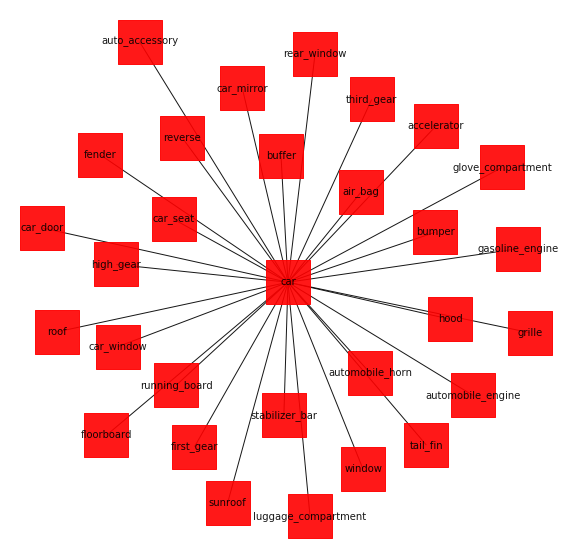

In [93]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G,with_labels=True,node_size=2000,
                 font_size=10,
                 node_shape='s',
                 alpha=0.9,
                 node_color='red')


Можно посчитать близость между синсетами (зависит от того, какой путь нужно пройти по этим связям от одного объекта до другого и есть ли он вообще)

In [94]:
car = wn.synsets('car')[0]
bike = wn.synsets('bike')[0]

In [95]:
bike.path_similarity(car)

0.3333333333333333

Есть и другие метрики:

In [96]:
# Leacock-Chodorow Similarity
wn.lch_similarity(bike, car)

2.538973871058276

In [97]:
# Wu-Palmer metric
wn.wup_similarity(bike, car)

0.9166666666666666

### Задание 2. Реализовать алгоритм Леска и проверить его на реальном датасете

Ворднет можно использовать для дизамбигуации. Самый простой алгоритм дизамбигуации - алгоритм Леска. В нём нужное значение слова находится через пересечение слов контекста, в котором употреблено это слово, с определениями значений слова из ворднета. Значение с максимальным пересечением - нужное.
Wordnet 可用于词义消歧。最简单的词义消歧算法--lesk。在其中，通过相交使用词的上下文和Wordnet的词义，找到所需的词义。 具有最大交集的值是所需的值。

Реализуйте его

In [209]:
def lesk( word, sentence ):
    """Ваш код тут"""
    bestsense = 0
    maxoverlap = 0
    #ваш код
    
    for i, syns in enumerate(synsets):
        # ваш код 
        
        
    return bestsense


In [ ]:
def lesk(word, sentence):
    """Ваш код тут"""
    bestsense = 0
    maxoverlap = 0
    #ваш код
    
    for i, syns in enumerate(synsets):
        # ваш код 
        
        
    return bestsense

Работать функция должна как-то так:

In [216]:
# на вход подается элемент результата работы уже написанной вами функции get_words_in_context
lesk('day', 'some point or period in time'.split()) # для примера контекст совпадает с одним из определений
# а на выходе индекс подходящего синсета

1

In [217]:
# с помощью этого индекса достаем нужный синсет
wn.synsets('day')[1].definition()

'some point or period in time'

**Проверьте насколько хорошо работает такой метод на реальном датасете.** http://lcl.uniroma1.it/wsdeval/ - большой фреймворк для оценки WSD. Там много данных и я взял кусочек, чтобы не было проблем с памятью

In [25]:
corpus_wsd = []
corpus = open('corpus_wsd_50k.txt').read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

Корпус состоит из предложений, где у каждого слова три поля - значение, лемма и само слово. Значение пустое, когда слово однозначное, а у многозначных слов стоит тэг вида **'long%3:00:02::'** Это тэг wordnet'ного формата

In [26]:
corpus_wsd[0]

[['', 'how', 'How'],
 ['long%3:00:02::', 'long', 'long'],
 ['', 'have', 'has'],
 ['', 'it', 'it'],
 ['be%2:42:03::', 'be', 'been'],
 ['', 'since', 'since'],
 ['', 'you', 'you'],
 ['review%2:31:00::', 'review', 'reviewed'],
 ['', 'the', 'the'],
 ['objective%1:09:00::', 'objective', 'objectives'],
 ['', 'of', 'of'],
 ['', 'you', 'your'],
 ['benefit%1:21:00::', 'benefit', 'benefit'],
 ['', 'and', 'and'],
 ['service%1:04:07::', 'service', 'service'],
 ['program%1:09:01::', 'program', 'program'],
 ['', '?', '?']]

Вот так можно достать соответствующий этому тэгу синсет:

In [220]:
wn.lemma_from_key('long%3:00:02::').synset()

Synset('long.a.01')

Когда с помощью алгоритма Леска вы найдете подходящее значение, их можно просто сравнить

In [223]:
wn.synsets('long')

[Synset('hanker.v.01'),
 Synset('long.a.01'),
 Synset('long.a.02'),
 Synset('long.s.03'),
 Synset('retentive.a.01'),
 Synset('long.a.05'),
 Synset('long.a.06'),
 Synset('long.s.07'),
 Synset('farseeing.s.02'),
 Synset('long.s.09'),
 Synset('long.r.01'),
 Synset('long.r.02')]

In [226]:
# тут подходит второй синсет
wn.synsets('long')[1] == wn.lemma_from_key('long%3:00:02::').synset()

True

In [227]:
# можно сравнить со всеми, чтобы убедиться
[(syns, wn.synsets('long')[i] == wn.lemma_from_key('long%3:00:02::').synset()) 
  for i, syns in enumerate(wn.synsets('long'))]

[(Synset('hanker.v.01'), False),
 (Synset('long.a.01'), True),
 (Synset('long.a.02'), False),
 (Synset('long.s.03'), False),
 (Synset('retentive.a.01'), False),
 (Synset('long.a.05'), False),
 (Synset('long.a.06'), False),
 (Synset('long.s.07'), False),
 (Synset('farseeing.s.02'), False),
 (Synset('long.s.09'), False),
 (Synset('long.r.01'), False),
 (Synset('long.r.02'), False)]

**Вам нужно для каждого многозначного слова (т.е. у него есть тэг в первом поле) с помощью алгоритма Леска предсказать нужный синсет и сравнить с правильным. Посчитайте процент правильных предсказаний (accuracy).**

Если считается слишком долго, возьмите поменьше предложений (например, только тысячу)

### Дополнительный балл

Если хотите заработать дополнительный балл, попробуйте улучшить алгоритм Леска любым способом (например, использовать расстояние редактирования вместо пересечения или даже вставить машинное обучение)